# Gibbs Sampler for mixture of Gaussians

We implement a Gibbs sampler for detecting the centers of a specified number of clusters based on a Gaussian mixture model. Work done by Rachel Levanger for Fall 2016 Foundation of Graphical Models at Columbia University, HW #2.

In [36]:
import math
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Some functions we'll use later

In [37]:
# Randomly choose num_clusters points according to N((0,0),variance) distribution in R^2
def get_cluster_means(num_clusters, variance):
    x, y = np.random.multivariate_normal([0,0], variance*np.identity(2) , num_clusters).T
    return x, y

## Generate the sample dataset

We specify K clusters and randomly select their means from a Gaussian distribution centered at zero with high variance (to spread them out). We then randomly choose a membership according to a uniform distribution for each datapoint, then generate that datpoint's position according to a multivariate normal distribution centered at the selected mean with some pre-specified variance common to all clusters

### Generate the means of the Gaussian mixture

In [38]:
# Set the number of clusters
K = 3

# Set the variance of the distribution of means
p_lambda = 50.

mu_x, mu_y = get_cluster_means(K, math.pow(p_lambda,2))

### Generate the sample data according to the generated means of the Gaussian mixture

In [39]:
# Set the number of datapoints in the sample
N = 60

# Set the variance of each of the clusters
sigma = 10.

# Initialize the dataset
x=np.zeros(N)
y=np.zeros(N)

# Loop through each datapoint and assign it to a cluster, then generate its position
for n in range(0,N):
    k = np.random.choice(K)
    x[n], y[n] = np.random.multivariate_normal([mu_x[k],mu_y[k]], math.pow(sigma,2)*np.identity(2) , 1).T

### Plot the sample data and the means

(-40.0, 140.0, -100.0, 20.0)

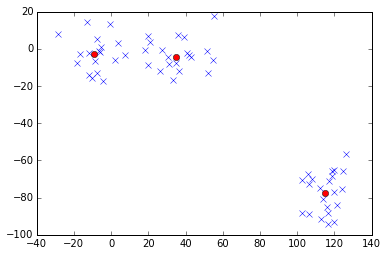

In [40]:
# Plot the means
plt.plot(x, y, 'x', markerfacecolor='blue')
plt.plot(mu_x, mu_y, 'x', marker='o', markerfacecolor='red')
plt.axis('equal')

## Implement the Gibbs sampler

### Initialize the sampler

In [41]:
# Initialize the mixture mean locations
gs_mu_x, gs_mu_y = get_cluster_means(K, 10)


# Initialize the mixture assignments
gs_z = np.random.choice(K,N)

### Iterate the sampler

In [42]:
# Set the number of iterations
iterations = 20

# Probability convergence table
p_iter = np.zeros(iterations)

# Iterate the Gibbs sampler
for t in range(0,iterations):

    # Update the z_i
    for i in range(0,N):
        
        # Initialize the probability distribution variable to use for Gibbs sampling
        p = np.zeros(K)
        
        # For each possible value k of z_i, get the probability that point x_i is in cluster k
        for k in range(0,K):
            p[k] = multivariate_normal.pdf([x[i],y[i]],mean=[gs_mu_x[k], gs_mu_y[k]], cov=math.pow(sigma,2)*np.identity(2))
        p = p*(1./K)
        p = p/sum(p) # normalize
        
        # Update z_i to a sample from the categorical distribution just discovered
        gs_z[i] = np.random.multinomial(1,p).nonzero()[0][0]

    # Update the mu_k
    for k in range(0,K):
        n_k = np.where(gs_z == k)[0].shape[0] # Number of data points in cluster k
        s_k = np.asarray([sum(x[np.where(gs_z == k)]), sum(y[np.where(gs_z == k)])]) # Sum of the points in cluster k 
        mu_hat = (n_k/sigma)/((n_k/sigma)+(1./p_lambda))*(s_k/n_k)
        lambda_hat = 1./(n_k/sigma + 1/p_lambda)
        gs_mu_x[k], gs_mu_y[k] = np.random.multivariate_normal(mu_hat, math.pow(lambda_hat,2)*np.identity(2), 1).T
    
    # Compute joint probability and update the convergence table
    for k in range(0,K):
        # Candidate means conditional on proirs
        p_iter[t] = p_iter[t] + math.log(multivariate_normal.pdf([gs_mu_x[k], gs_mu_y[k]],mean=[0,0],cov=math.pow(p_lambda,2)*np.identity(2)))
    for i in range(0,N):
        # Candidate assignments conditional on proirs
        p_iter[t] = p_iter[t] + math.log(1./K)
        # Likelihood terms
        p_iter[t] = p_iter[t] - (1./(2.*math.pow(sigma,2)))*math.pow(np.linalg.norm(np.asarray([x[i],y[i]])-np.asarray([gs_mu_x[gs_z[i]], gs_mu_y[gs_z[i]]])),2)
    

### Plot the results

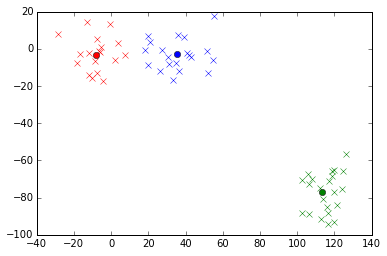

In [43]:
color=['red', 'blue', 'green', 'yellow', 'cyan', 'magenta']
for k in range(0,K):
    plt.plot(x[np.where(gs_z == k)], y[np.where(gs_z == k)], 'x', color=color[k])
    plt.plot(gs_mu_x[k], gs_mu_y[k], 'x', marker='o', markerfacecolor=color[k])
    plt.axis('equal')

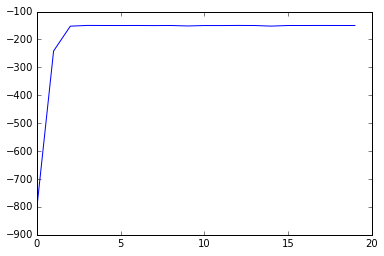

In [44]:
plt.plot(range(0,iterations), p_iter)